In [1]:
!pip install transformers datasets torchaudio scikit-learn matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Jika ingin menggunakan GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## train model 1 (bhs indonesia) whisper base

In [1]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [2]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [3]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [4]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [5]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [6]:
from transformers import TrainerCallback, TrainerControl, TrainerState, Trainer
from typing import Optional, Dict, Any

class AccuracyThresholdCallback(TrainerCallback):
    def __init__(self, threshold: float = 0.99):
        self.threshold = threshold

    def on_evaluate(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        metrics: Optional[Dict[str, float]] = None,
        **kwargs,
    ):
        acc = metrics.get("eval_accuracy")
        if acc is not None and acc >= self.threshold:
            print(f"\n✅ Accuracy threshold {self.threshold*100:.2f}% reached (eval_accuracy={acc:.4f}). Stopping training.")
            control.should_training_stop = True


In [7]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name, threshold=0.97):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     evaluation_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-5,
    #     per_device_train_batch_size=1,
    #     per_device_eval_batch_size=1,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     logging_dir=os.path.join(output_dir, "logs"),
    #     seed=42,
    #     fp16=True,
    #     max_grad_norm=1.0,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    # )
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-4,
    #     per_device_train_batch_size=2,       # coba lebih kecil kalau GPU limit
    #     per_device_eval_batch_size=2,
    #     gradient_accumulation_steps=4,       # untuk tetap effective batch size sama
    #     num_train_epochs=5,
    #     # warmup_ratio=0.1,
    #     # weight_decay=0.005,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     # load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     logging_steps=10,
    #     lr_scheduler_type="linear"
    # )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # trainer = Trainer(
    #     model=model,
    #     args=training_args,
    #     train_dataset=train_dataset,
    #     eval_dataset=eval_dataset,
    #     compute_metrics=compute_metrics,
    #     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    # )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            AccuracyThresholdCallback(threshold=threshold)  # ✅ stop kalau eval_accuracy >= 99%
        ],
    )


    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [11]:
import wandb
wandb.init(mode="disabled")

In [9]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/indonesia"
base_model_name = "openai/whisper-base"
# base_model_name = "openai/whisper-tiny"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

print("\n✅ Data Loaded")
print(df.head())
print(df['label'].value_counts())
print("\nTrain Split:")
print(train_df['label'].value_counts())
print("\nTest Split:")
print(test_df['label'].value_counts())


✅ Loaded and split dataset
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64

✅ Data Loaded
                                                path    label  label_id
0  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
1  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
2  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
3  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
4  /content/drive/MyDrive/dataset/datasetindo_sor...  neutral         2
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64

Train Split:
label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64

Test Split:
label
disgust     12
surpr

In [10]:
print((label2id))

{'disgust': 0, 'happy': 1, 'neutral': 2, 'surprise': 3}


In [11]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Processor Loaded


In [12]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


In [13]:
print((id2label))

{0: 'disgust', 1: 'happy', 2: 'neutral', 3: 'surprise'}


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.385000,1.330750,0.541667,0.415409,0.512857,0.541667
2,1.003800,0.731908,0.708333,0.676637,0.797222,0.708333
3,0.329000,0.319288,0.937500,0.936508,0.950000,0.937500
4,0.132200,0.150727,0.958333,0.957273,0.961538,0.958333
5,0.031800,0.106933,0.937500,0.935055,0.945055,0.937500
6,0.006100,0.051563,0.979167,0.979130,0.980769,0.979167


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 


✅ Accuracy threshold 97.00% reached (eval_accuracy=0.9792). Stopping training.


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50


✅ Accuracy threshold 97.00% reached (eval_accuracy=0.9792). Stopping training.

=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.92      0.96        12
       happy       1.00      1.00      1.00        12
     neutral       0.92      1.00      0.96        12
    surprise       1.00      1.00      1.00        12

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



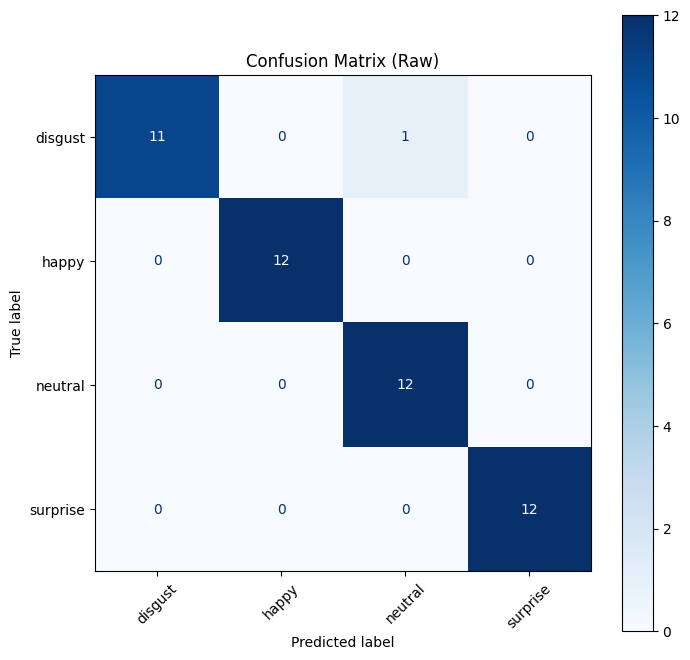

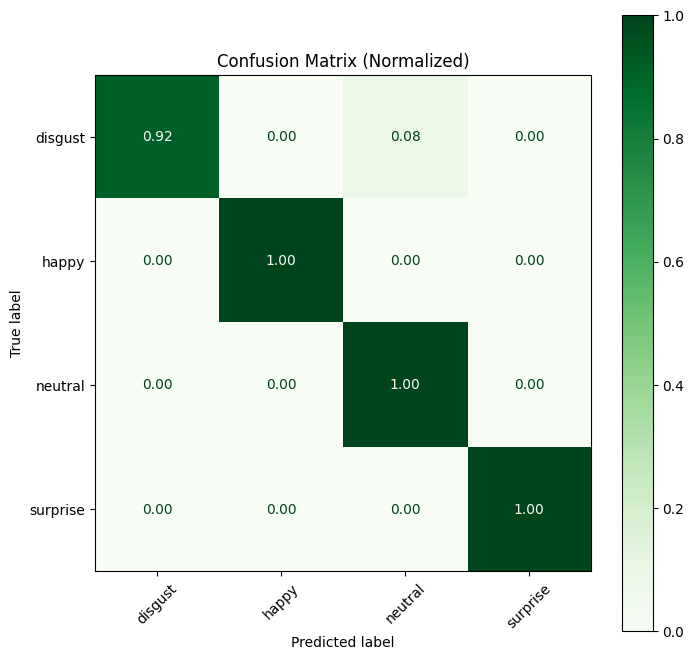

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/indonesia


In [14]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## test model 1 (bhs indonesia) dengan bahasa inggris whisper base

In [40]:
# === 0. Load Model & Processor
from transformers import WhisperProcessor, WhisperForAudioClassification
from datasets import Dataset, Audio

In [41]:
# path ke model Indonesia yang sudah dilatih
model_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/indonesia/checkpoint-144"


In [42]:
processor = WhisperProcessor.from_pretrained(model_dir)
model = WhisperForAudioClassification.from_pretrained(model_dir)

In [43]:

# === 1. Load data Inggris
english_data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
# english_data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
allowed_labels = ["disgust", "happy", "neutral", "surprise"]

english_df = load_data_from_folder(english_data_dir, allowed_labels)
english_df, _, _ = encode_labels(english_df)

test_dataset = Dataset.from_pandas(english_df)
test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

In [44]:
# === 2. Preprocess
def preprocess(batch):
    audio_array = batch["path"]["array"]
    mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
    mel = np.array(mel).squeeze()
    mel = pad_or_truncate_mel(mel, 3000)
    return {"input_features": mel, "labels": batch["label_id"]}

test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

Map:   0%|          | 0/240 [00:00<?, ? examples/s]


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.27      0.98      0.43        60
       happy       0.00      0.00      0.00        60
     neutral       0.89      0.13      0.23        60
    surprise       0.40      0.07      0.11        60

    accuracy                           0.30       240
   macro avg       0.39      0.30      0.19       240
weighted avg       0.39      0.30      0.19       240



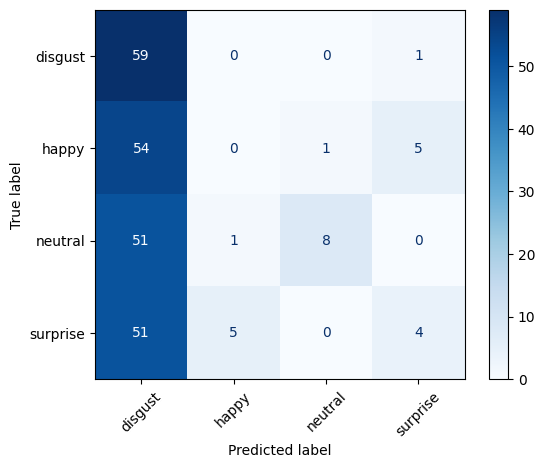

In [45]:
# === 3. Run prediction
from transformers import Trainer
trainer = Trainer(model=model)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n=== Classification Report ===")
target_names = sorted(english_df["label"].unique())
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.98      0.99        60
       happy       1.00      1.00      1.00        60
     neutral       0.98      1.00      0.99        60
    surprise       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



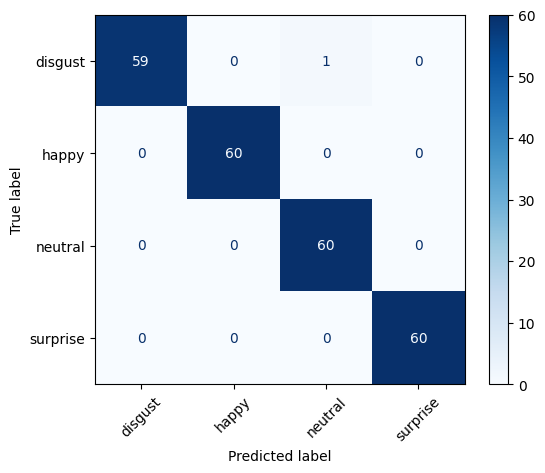

In [39]:
# === 3. Run prediction
from transformers import Trainer
trainer = Trainer(model=model)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n=== Classification Report ===")
target_names = sorted(english_df["label"].unique())
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.27      0.98      0.43        60
       happy       0.00      0.00      0.00        60
     neutral       0.89      0.13      0.23        60
    surprise       0.40      0.07      0.11        60

    accuracy                           0.30       240
   macro avg       0.39      0.30      0.19       240
weighted avg       0.39      0.30      0.19       240



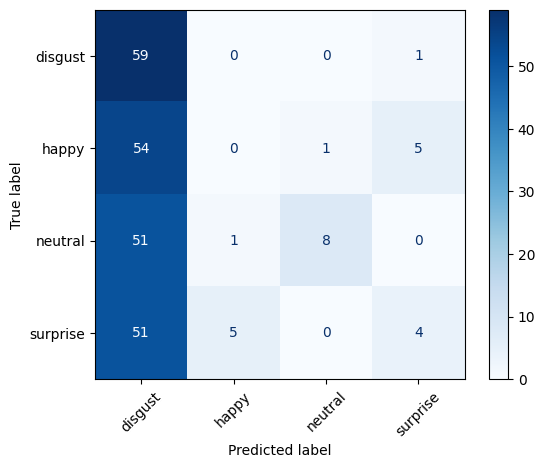

In [33]:
# === 3. Run prediction
from transformers import Trainer
trainer = Trainer(model=model)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n=== Classification Report ===")
target_names = sorted(english_df["label"].unique())
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

In [ ]:
from transformers import WhisperForAudioClassification

# Load model (misalnya dari Hugging Face Hub)
model = WhisperForAudioClassification.from_pretrained("openai/whisper-base")

# Print arsitektur
print(model)


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affi

## train model 2 (bhs inggris) whisper base

In [1]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [2]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [3]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [4]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [5]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [6]:
from transformers import TrainerCallback, TrainerControl, TrainerState, Trainer
from typing import Optional, Dict, Any

class AccuracyThresholdCallback(TrainerCallback):
    def __init__(self, threshold: float = 0.99):
        self.threshold = threshold

    def on_evaluate(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        metrics: Optional[Dict[str, float]] = None,
        **kwargs,
    ):
        acc = metrics.get("eval_accuracy")
        if acc is not None and acc >= self.threshold:
            print(f"\n✅ Accuracy threshold {self.threshold*100:.2f}% reached (eval_accuracy={acc:.4f}). Stopping training.")
            control.should_training_stop = True


In [7]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name, threshold=0.97):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     evaluation_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-5,
    #     per_device_train_batch_size=1,
    #     per_device_eval_batch_size=1,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     logging_dir=os.path.join(output_dir, "logs"),
    #     seed=42,
    #     fp16=True,
    #     max_grad_norm=1.0,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    # )
    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-4,
    #     per_device_train_batch_size=2,       # coba lebih kecil kalau GPU limit
    #     per_device_eval_batch_size=2,
    #     gradient_accumulation_steps=4,       # untuk tetap effective batch size sama
    #     num_train_epochs=5,
    #     # warmup_ratio=0.1,
    #     # weight_decay=0.005,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     # load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     logging_steps=10,
    #     lr_scheduler_type="linear"
    # )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # trainer = Trainer(
    #     model=model,
    #     args=training_args,
    #     train_dataset=train_dataset,
    #     eval_dataset=eval_dataset,
    #     compute_metrics=compute_metrics,
    #     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    # )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            AccuracyThresholdCallback(threshold=threshold)  # ✅ stop kalau eval_accuracy >= 99%
        ],
    )


    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [8]:
import wandb
wandb.init(mode="disabled")

In [9]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel-copy/inggris"
base_model_name = "openai/whisper-base"
# base_model_name = "openai/whisper-tiny"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

print("\n✅ Data Loaded")
print(df.head())
print(df['label'].value_counts())
print("\nTrain Split:")
print(train_df['label'].value_counts())
print("\nTest Split:")
print(test_df['label'].value_counts())


✅ Loaded and split dataset
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64

✅ Data Loaded
                                                path     label  label_id
0  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
1  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
2  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
3  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
4  /content/drive/MyDrive/dataset/normalized_audi...  surprise         3
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64

Train Split:
label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64

Test Split:
label
disgust     12

In [10]:
print((label2id))

{'disgust': 0, 'happy': 1, 'neutral': 2, 'surprise': 3}


In [11]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Processor Loaded


In [12]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


In [13]:
print((id2label))

{0: 'disgust', 1: 'happy', 2: 'neutral', 3: 'surprise'}


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.374300,1.308309,0.354167,0.229167,0.187500,0.354167
2,1.031200,0.792180,0.770833,0.743934,0.818137,0.770833
3,0.307000,0.316193,0.958333,0.958042,0.964286,0.958333
4,0.168000,0.384674,0.895833,0.892015,0.899420,0.895833
5,0.109500,0.192256,0.937500,0.937391,0.938811,0.937500
6,0.063600,0.260441,0.937500,0.937273,0.942308,0.937500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        12
       happy       0.86      1.00      0.92        12
     neutral       1.00      0.83      0.91        12
    surprise       1.00      1.00      1.00        12

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



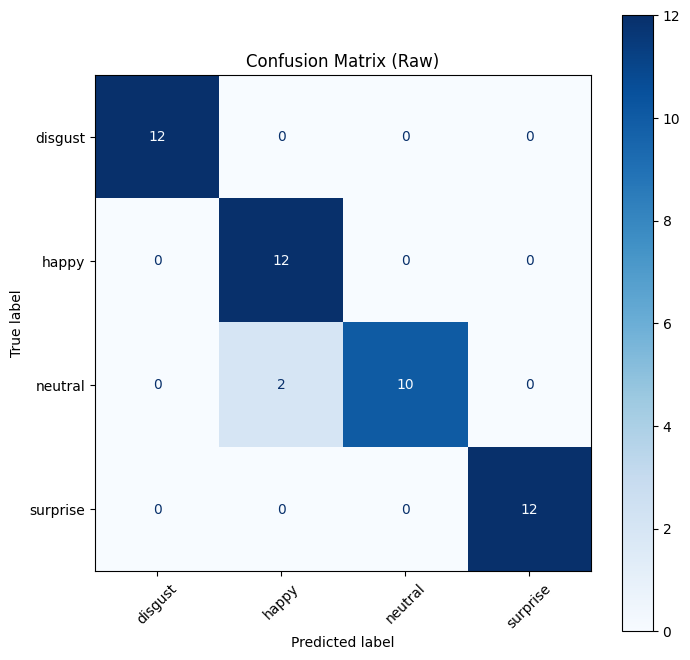

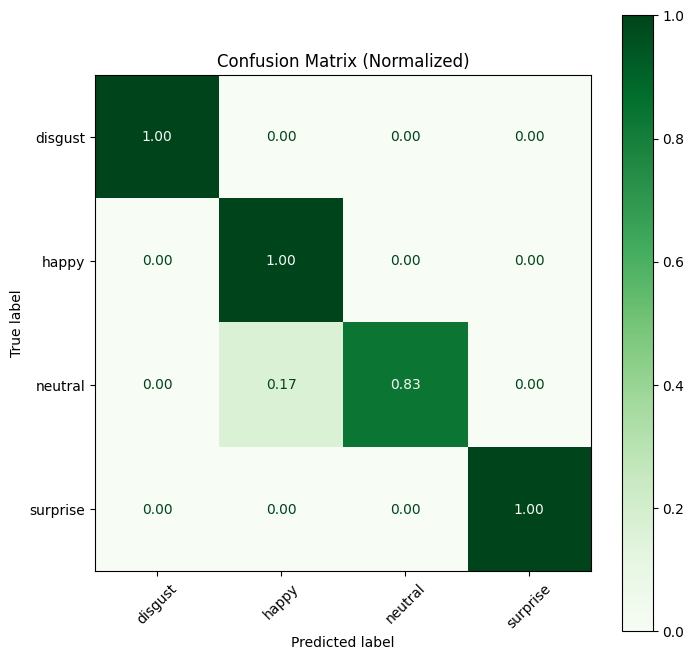

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel-copy/inggris


In [14]:
# Train2
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.376600,1.296549,0.520833,0.400257,0.500952,0.520833
2,1.061900,0.983027,0.708333,0.658054,0.780147,0.708333
3,0.417400,0.420585,0.916667,0.912222,0.930769,0.916667
4,0.097900,0.399398,0.875000,0.867663,0.897436,0.875000
5,0.088300,0.584965,0.875000,0.868396,0.901786,0.875000
6,0.025800,0.405218,0.916667,0.914545,0.917308,0.916667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        12
       happy       1.00      0.67      0.80        12
     neutral       0.80      1.00      0.89        12
    surprise       0.92      1.00      0.96        12

    accuracy                           0.92        48
   macro avg       0.93      0.92      0.91        48
weighted avg       0.93      0.92      0.91        48



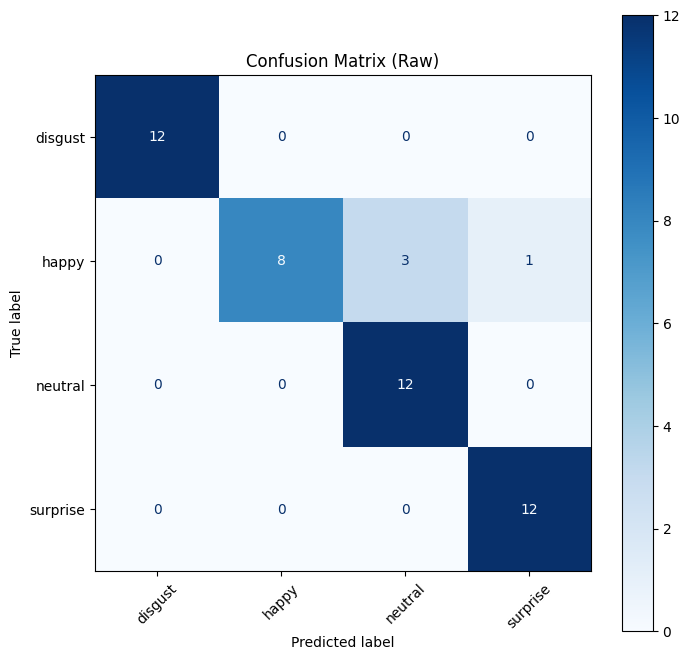

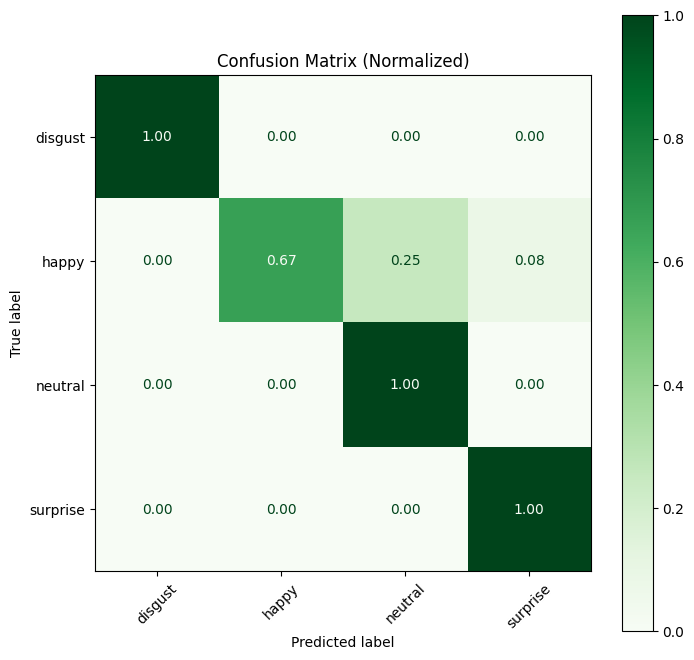

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/inggris


In [18]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## test model 2 (bhs inggris) dengan bahasa indonesia whisper base

In [12]:
# === 0. Load Model & Processor
from transformers import WhisperProcessor, WhisperForAudioClassification
from datasets import Dataset, Audio

In [13]:
# path ke model Indonesia yang sudah dilatih
model_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/inggris/checkpoint-144"


In [14]:
processor = WhisperProcessor.from_pretrained(model_dir)
model = WhisperForAudioClassification.from_pretrained(model_dir)

In [15]:

# === 1. Load data Inggris
english_data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
# english_data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
allowed_labels = ["disgust", "happy", "neutral", "surprise"]

english_df = load_data_from_folder(english_data_dir, allowed_labels)
english_df, _, _ = encode_labels(english_df)

test_dataset = Dataset.from_pandas(english_df)
test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

In [16]:
# === 2. Preprocess
def preprocess(batch):
    audio_array = batch["path"]["array"]
    mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
    mel = np.array(mel).squeeze()
    mel = pad_or_truncate_mel(mel, 3000)
    return {"input_features": mel, "labels": batch["label_id"]}

test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

Map:   0%|          | 0/240 [00:00<?, ? examples/s]


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        60
       happy       0.98      0.95      0.97        60
     neutral       0.97      0.98      0.98        60
    surprise       0.98      1.00      0.99        60

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



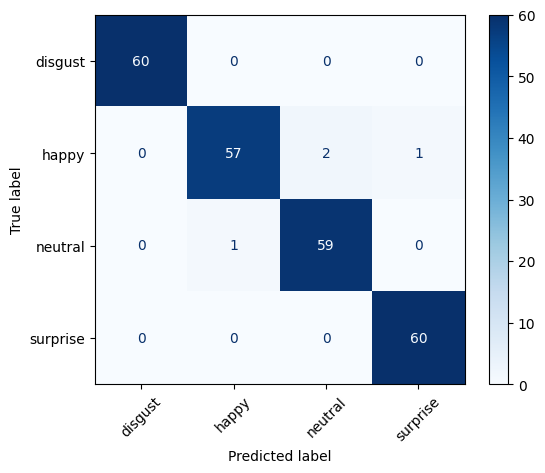

In [17]:
# === 3. Run prediction
from transformers import Trainer
trainer = Trainer(model=model)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n=== Classification Report ===")
target_names = sorted(english_df["label"].unique())
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.03      0.06        60
       happy       0.28      0.30      0.29        60
     neutral       0.85      0.78      0.82        60
    surprise       0.47      0.93      0.63        60

    accuracy                           0.51       240
   macro avg       0.65      0.51      0.45       240
weighted avg       0.65      0.51      0.45       240



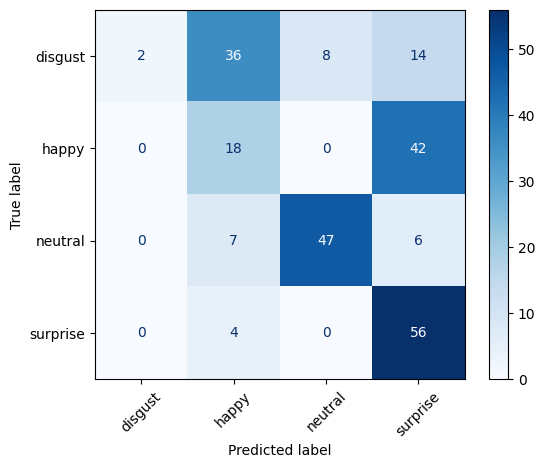

In [64]:
# === 3. Run prediction
from transformers import Trainer
trainer = Trainer(model=model)

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

print("\n=== Classification Report ===")
target_names = sorted(english_df["label"].unique())
print(classification_report(labels, preds, target_names=target_names))

cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

In [ ]:
from transformers import WhisperForAudioClassification

# Load model (misalnya dari Hugging Face Hub)
model = WhisperForAudioClassification.from_pretrained("openai/whisper-base")

# Print arsitektur
print(model)


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


WhisperForAudioClassification(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0-5): 6 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affi

## train model 3 (bhs gabungan) whisper base

In [21]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [22]:
# =========================================================
# === 1. LOAD DATA
# =========================================================
def load_data_from_folder(data_dir, allowed_labels, origin_tag):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower(),
                        "origin": origin_tag
                    })
    return pd.DataFrame(all_data)

In [23]:
# =========================================================
# === 2. BALANCE DATA PER LABEL DAN ASAL
# =========================================================
def balance_per_label_and_origin(df):
    balanced_parts = []
    for label in df['label'].unique():
        for origin in df['origin'].unique():
            part = df[(df['label'] == label) & (df['origin'] == origin)]
            if len(part) == 0:
                continue
            n_min = part.shape[0]
            balanced_parts.append(part.sample(n=n_min, random_state=42))
    return pd.concat(balanced_parts).reset_index(drop=True)

In [24]:
# =========================================================
# === 3. STRATIFIED SPLIT PER ORIGIN
# =========================================================
def stratified_split_per_origin(df, test_size=0.2, seed=42):
    train_parts = []
    test_parts = []
    for origin in df['origin'].unique():
        df_origin = df[df['origin'] == origin]
        train_df, test_df = train_test_split(
            df_origin,
            test_size=test_size,
            stratify=df_origin["label"],
            random_state=seed
        )
        train_parts.append(train_df)
        test_parts.append(test_df)
    train = pd.concat(train_parts).reset_index(drop=True)
    test = pd.concat(test_parts).reset_index(drop=True)
    return train, test

In [25]:
# =========================================================
# === 4. ENCODE LABELS
# =========================================================
def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

In [26]:
# =========================================================
# === 5. PAD/TRUNCATE MEL
# =========================================================
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel

In [27]:
# =========================================================
# === 6. PREPARE DATASET
# =========================================================
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()
        mel = pad_or_truncate_mel(mel, 3000)
        return {"input_features": mel, "labels": batch["label_id"]}

    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label", "origin"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label", "origin"])

    return train_dataset, test_dataset

In [28]:
# =========================================================
# === 7. METRICS
# =========================================================
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

In [29]:
from transformers import TrainerCallback, TrainerControl, TrainerState, Trainer
from typing import Optional, Dict, Any

class AccuracyThresholdCallback(TrainerCallback):
    def __init__(self, threshold: float = 0.99):
        self.threshold = threshold

    def on_evaluate(
        self,
        args: TrainingArguments,
        state: TrainerState,
        control: TrainerControl,
        metrics: Optional[Dict[str, float]] = None,
        **kwargs,
    ):
        acc = metrics.get("eval_accuracy")
        if acc is not None and acc >= self.threshold:
            print(f"\n✅ Accuracy threshold {self.threshold*100:.2f}% reached (eval_accuracy={acc:.4f}). Stopping training.")
            control.should_training_stop = True


In [30]:
# =========================================================
# === 8. TRAINING FUNCTION
# =========================================================
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name, threshold=0.97):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     eval_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-4,
    #     per_device_train_batch_size=2,
    #     per_device_eval_batch_size=2,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     seed=42,
    #     fp16=True,
    #     save_total_limit=2,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    #     logging_steps=10,
    #     lr_scheduler_type="linear"
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,                          # ✅ lebih kecil → stabil untuk data kecil
        per_device_train_batch_size=2,              # ✅ batch kecil → lebih hati-hati
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,              # ✅ agar batch efektif tetap besar
        num_train_epochs=10,                        # ✅ cukup banyak, tapi early stopping akan batasi
        warmup_ratio=0.1,                           # ✅ pemanasan, penting untuk dataset kecil
        weight_decay=0.01,                          # ✅ regularisasi ringan
        logging_steps=10,
        seed=42,
        fp16=True,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        lr_scheduler_type="linear"
    )

    # trainer = Trainer(
    #     model=model,
    #     args=training_args,
    #     train_dataset=train_dataset,
    #     eval_dataset=eval_dataset,
    #     compute_metrics=compute_metrics,
    #     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    # )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=3),
            AccuracyThresholdCallback(threshold=threshold)  # ✅ stop kalau eval_accuracy >= 99%
        ],
    )

    trainer.train()
    trainer.evaluate()

    # === Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")

    # === Classification Report
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrices
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)
    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

In [31]:
# =========================================================
# === 9. MAIN PIPELINE
# =========================================================
import wandb
wandb.init(mode="disabled")

In [32]:
# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
indo_data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
ravdess_data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/gabungan"
# output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/inggris"
base_model_name = "openai/whisper-base"

In [33]:
# Load
df_indo = load_data_from_folder(indo_data_dir, allowed_labels, "indo")
df_ravdess = load_data_from_folder(ravdess_data_dir, allowed_labels, "ravdess")
df_all = pd.concat([df_indo, df_ravdess]).reset_index(drop=True)

print(f"✅ Loaded dataset: {df_all['label'].value_counts()}")

✅ Loaded dataset: label
neutral     120
surprise    120
disgust     120
happy       120
Name: count, dtype: int64


In [34]:
# Balance per label and origin
df_all = df_all.groupby(['label', 'origin']).apply(
    lambda x: x.sample(x.shape[0], random_state=42)
).reset_index(drop=True)

/tmp/ipython-input-34-4246443958.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby(['label', 'origin']).apply(


In [35]:
# Stratified split per origin
train_df, test_df = stratified_split_per_origin(df_all)

In [36]:
# Encode labels
df_all, label2id, id2label = encode_labels(df_all)
train_df = train_df.merge(df_all[["path", "label_id"]], on="path", how="left")
test_df = test_df.merge(df_all[["path", "label_id"]], on="path", how="left")


In [37]:
print(f"✅ Train size: {len(train_df)}, Test size: {len(test_df)}")
print("Train label distribution:\n", train_df.groupby(['label', 'origin']).size())
print("Test label distribution:\n", test_df.groupby(['label', 'origin']).size())

✅ Train size: 384, Test size: 96
Train label distribution:
 label     origin 
disgust   indo       48
          ravdess    48
happy     indo       48
          ravdess    48
neutral   indo       48
          ravdess    48
surprise  indo       48
          ravdess    48
dtype: int64
Test label distribution:
 label     origin 
disgust   indo       12
          ravdess    12
happy     indo       12
          ravdess    12
neutral   indo       12
          ravdess    12
surprise  indo       12
          ravdess    12
dtype: int64


In [38]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

✅ Processor Loaded


In [39]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

✅ Dataset Prepared


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.291200,1.104767,0.500000,0.441600,0.570618,0.500000
2,0.694100,0.605066,0.791667,0.760088,0.800154,0.791667
3,0.289000,0.319475,0.906250,0.905814,0.910391,0.906250
4,0.058600,0.701029,0.843750,0.849706,0.887143,0.843750
5,0.032600,0.528816,0.864583,0.871379,0.902922,0.864583
6,0.003100,0.435364,0.916667,0.914972,0.916126,0.916667
7,0.009400,0.466602,0.895833,0.896048,0.901154,0.895833
8,0.001700,0.427773,0.895833,0.896048,0.901154,0.895833
9,0.001600,0.419628,0.895833,0.895778,0.896970,0.895833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-epoch-basemodel/gabungan

=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.92      1.00      0.96        24
       happy       0.90      0.79      0.84        24
     neutral       0.92      0.92      0.92        24
    surprise       0.92      0.96      0.94        24

    accuracy                           0.92        96
   macro avg       0.92      0.92      0.91        96
weighted avg       0.92      0.92      0.91        96



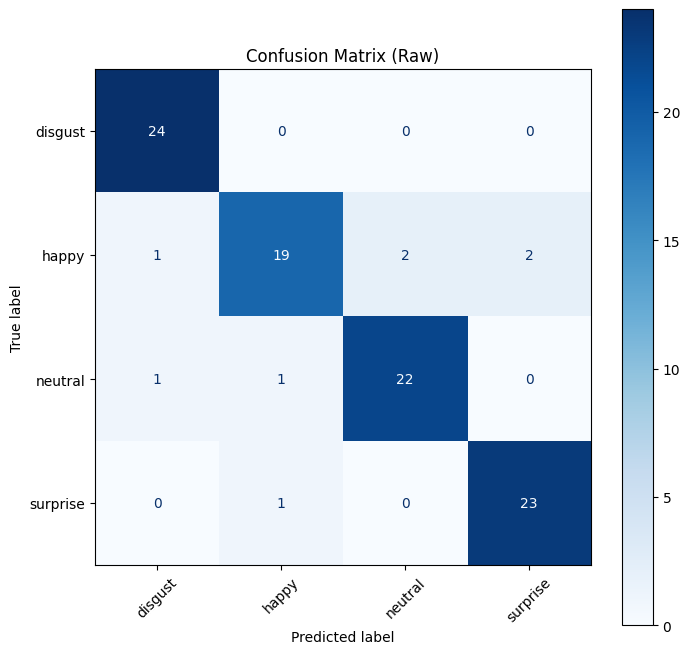

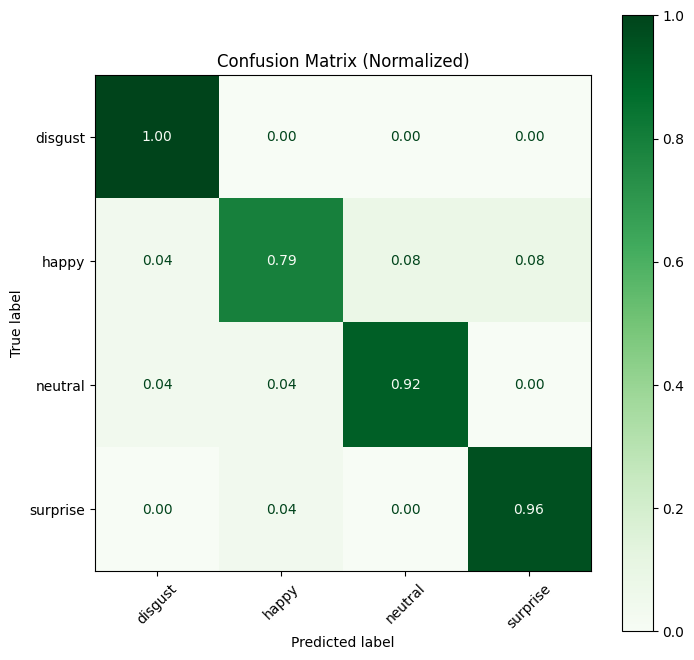

In [40]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

## train model 1 (bhs indonesia) whisper tiny

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [ ]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [ ]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     evaluation_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-5,
    #     per_device_train_batch_size=1,
    #     per_device_eval_batch_size=1,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     logging_dir=os.path.join(output_dir, "logs"),
    #     seed=42,
    #     fp16=True,
    #     max_grad_norm=1.0,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=2,       # coba lebih kecil kalau GPU limit
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,       # untuk tetap effective batch size sama
        num_train_epochs=5,
        # warmup_ratio=0.1,
        # weight_decay=0.005,
        seed=42,
        fp16=True,
        save_total_limit=2,
        # load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_steps=10,
        lr_scheduler_type="linear"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/indonesia"
# base_model_name = "openai/whisper-base"
base_model_name = "openai/whisper-tiny"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

# # Processor
# processor = WhisperProcessor.from_pretrained(base_model_name)
# print("✅ Processor Loaded")

# # Dataset
# train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
# print("✅ Dataset Prepared")

# import wandb
# wandb.init(mode="disabled")

# # Train
# train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)


✅ Loaded and split dataset
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [ ]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

✅ Processor Loaded


In [ ]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.215300,0.698252,0.770833,0.754893,0.845395,0.770833
2,0.414100,0.347522,0.916667,0.915638,0.930769,0.916667
3,0.115100,0.268717,0.937500,0.935055,0.945055,0.937500
4,0.009100,0.221352,0.958333,0.957273,0.961538,0.958333
5,0.009000,0.213408,0.958333,0.957273,0.961538,0.958333


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.83      0.91        12
       happy       0.92      1.00      0.96        12
     neutral       0.92      1.00      0.96        12
    surprise       1.00      1.00      1.00        12

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



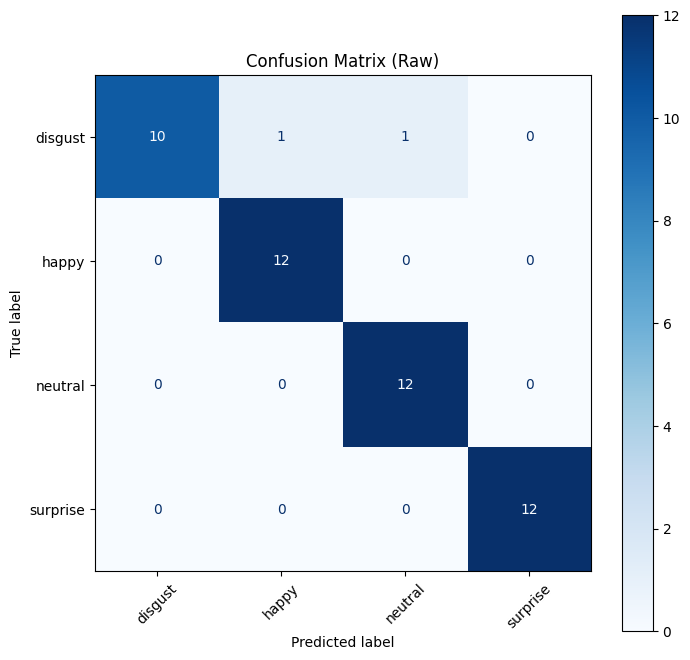

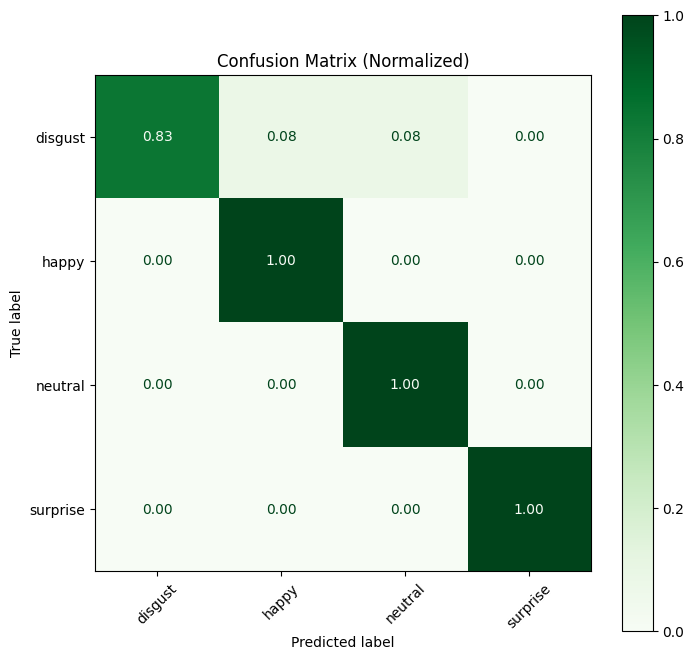

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/indonesia


In [ ]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## train model 1 (bhs indonesia) whisper firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from transformers import AutoProcessor, AutoModelForAudioClassification

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [ ]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [ ]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        "firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3",
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     evaluation_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-5,
    #     per_device_train_batch_size=1,
    #     per_device_eval_batch_size=1,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     logging_dir=os.path.join(output_dir, "logs"),
    #     seed=42,
    #     fp16=True,
    #     max_grad_norm=1.0,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=2,       # coba lebih kecil kalau GPU limit
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,       # untuk tetap effective batch size sama
        num_train_epochs=5,
        # warmup_ratio=0.1,
        # weight_decay=0.005,
        seed=42,
        fp16=True,
        save_total_limit=2,
        # load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_steps=10,
        lr_scheduler_type="linear"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch-firdhokk/indonesia"
# base_model_name = "openai/whisper-base"
# base_model_name = "openai/whisper-tiny"
processor = "openai/whisper-large-v3"
# base_model_name = "firdhokk/speech-emotion-recognition-with-openai-whisper-large-v3"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

# # Processor
# processor = WhisperProcessor.from_pretrained(base_model_name)
# print("✅ Processor Loaded")

# # Dataset
# train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
# print("✅ Dataset Prepared")

# import wandb
# wandb.init(mode="disabled")

# # Train
# train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)


✅ Loaded and split dataset
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [ ]:
# Processor
processor = WhisperProcessor.from_pretrained(processor)
print("✅ Processor Loaded")

✅ Processor Loaded


In [ ]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


In [ ]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([4]).

In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## train model 2 (bhs inggris) whisper tiny

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [ ]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [ ]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    # training_args = TrainingArguments(
    #     output_dir=output_dir,
    #     evaluation_strategy="epoch",
    #     save_strategy="epoch",
    #     learning_rate=1e-5,
    #     per_device_train_batch_size=1,
    #     per_device_eval_batch_size=1,
    #     gradient_accumulation_steps=4,
    #     num_train_epochs=5,
    #     warmup_ratio=0.1,
    #     weight_decay=0.005,
    #     logging_steps=10,
    #     logging_dir=os.path.join(output_dir, "logs"),
    #     seed=42,
    #     fp16=True,
    #     max_grad_norm=1.0,
    #     save_total_limit=2,
    #     load_best_model_at_end=True,
    #     metric_for_best_model="accuracy",
    #     greater_is_better=True,
    # )
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=2,       # coba lebih kecil kalau GPU limit
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,       # untuk tetap effective batch size sama
        num_train_epochs=5,
        # warmup_ratio=0.1,
        # weight_decay=0.005,
        seed=42,
        fp16=True,
        save_total_limit=2,
        # load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_steps=10,
        lr_scheduler_type="linear"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/inggris"
# base_model_name = "openai/whisper-base"
base_model_name = "openai/whisper-tiny"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

# # Processor
# processor = WhisperProcessor.from_pretrained(base_model_name)
# print("✅ Processor Loaded")

# # Dataset
# train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
# print("✅ Dataset Prepared")

# import wandb
# wandb.init(mode="disabled")

# # Train
# train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)


✅ Loaded and split dataset
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


In [ ]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Processor Loaded


In [ ]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.393200,1.375285,0.250000,0.100000,0.062500,0.250000
2,1.192800,0.852694,0.645833,0.600130,0.667642,0.645833
3,0.631300,0.893466,0.666667,0.640097,0.724561,0.666667
4,0.323900,0.526560,0.833333,0.834773,0.841346,0.833333
5,0.227500,0.517037,0.812500,0.786353,0.866667,0.812500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.92      0.96        12
       happy       1.00      0.33      0.50        12
     neutral       0.67      1.00      0.80        12
    surprise       0.80      1.00      0.89        12

    accuracy                           0.81        48
   macro avg       0.87      0.81      0.79        48
weighted avg       0.87      0.81      0.79        48



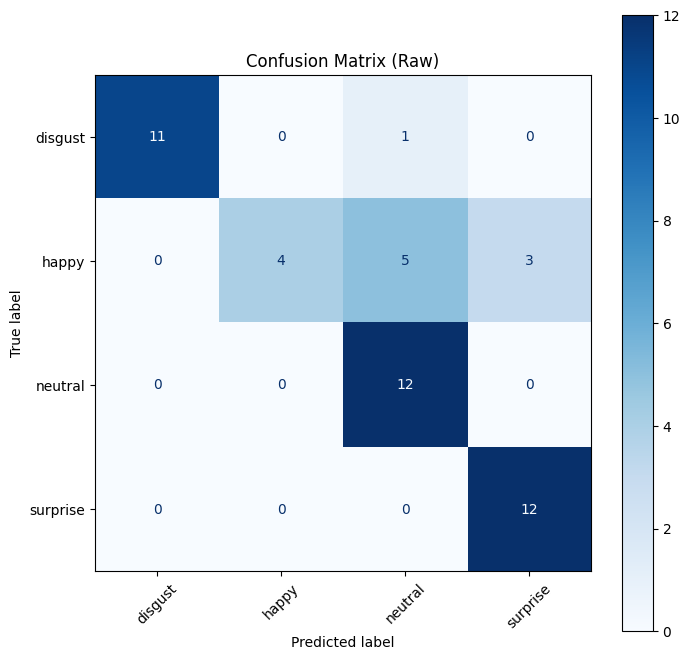

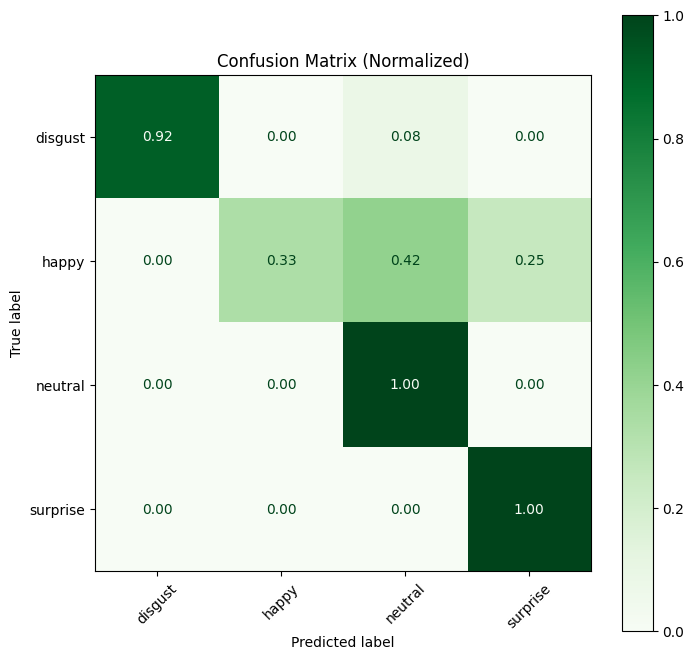

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/inggris


In [ ]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## train model 3 (bhs gabungan) whisper tiny

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
# =========================================================
# === 1. LOAD DATA
# =========================================================
def load_data_from_folder(data_dir, allowed_labels, origin_tag):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower(),
                        "origin": origin_tag
                    })
    return pd.DataFrame(all_data)

In [ ]:
# =========================================================
# === 2. BALANCE DATA PER LABEL DAN ASAL
# =========================================================
def balance_per_label_and_origin(df):
    balanced_parts = []
    for label in df['label'].unique():
        for origin in df['origin'].unique():
            part = df[(df['label'] == label) & (df['origin'] == origin)]
            if len(part) == 0:
                continue
            n_min = part.shape[0]
            balanced_parts.append(part.sample(n=n_min, random_state=42))
    return pd.concat(balanced_parts).reset_index(drop=True)

In [ ]:
# =========================================================
# === 3. STRATIFIED SPLIT PER ORIGIN
# =========================================================
def stratified_split_per_origin(df, test_size=0.2, seed=42):
    train_parts = []
    test_parts = []
    for origin in df['origin'].unique():
        df_origin = df[df['origin'] == origin]
        train_df, test_df = train_test_split(
            df_origin,
            test_size=test_size,
            stratify=df_origin["label"],
            random_state=seed
        )
        train_parts.append(train_df)
        test_parts.append(test_df)
    train = pd.concat(train_parts).reset_index(drop=True)
    test = pd.concat(test_parts).reset_index(drop=True)
    return train, test

In [ ]:
# =========================================================
# === 4. ENCODE LABELS
# =========================================================
def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

In [ ]:
# =========================================================
# === 5. PAD/TRUNCATE MEL
# =========================================================
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel

In [ ]:
# =========================================================
# === 6. PREPARE DATASET
# =========================================================
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()
        mel = pad_or_truncate_mel(mel, 3000)
        return {"input_features": mel, "labels": batch["label_id"]}

    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label", "origin"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label", "origin"])

    return train_dataset, test_dataset

In [ ]:
# =========================================================
# === 7. METRICS
# =========================================================
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }

In [ ]:
# =========================================================
# === 8. TRAINING FUNCTION
# =========================================================
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-4,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,
        num_train_epochs=5,
        seed=42,
        fp16=True,
        save_total_limit=2,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        logging_steps=10,
        lr_scheduler_type="linear"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")

    # === Classification Report
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrices
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)
    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.show()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.show()

In [ ]:
# =========================================================
# === 9. MAIN PIPELINE
# =========================================================
import wandb
wandb.init(mode="disabled")

In [ ]:
# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
indo_data_dir = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
ravdess_data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/gabungan"
# output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/inggris"
base_model_name = "openai/whisper-tiny"

In [ ]:
# Load
df_indo = load_data_from_folder(indo_data_dir, allowed_labels, "indo")
df_ravdess = load_data_from_folder(ravdess_data_dir, allowed_labels, "ravdess")
df_all = pd.concat([df_indo, df_ravdess]).reset_index(drop=True)

print(f"✅ Loaded dataset: {df_all['label'].value_counts()}")

✅ Loaded dataset: label
neutral     120
surprise    120
disgust     120
happy       120
Name: count, dtype: int64


In [ ]:
# Balance per label and origin
df_all = df_all.groupby(['label', 'origin']).apply(
    lambda x: x.sample(x.shape[0], random_state=42)
).reset_index(drop=True)

/tmp/ipython-input-24-4246443958.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all = df_all.groupby(['label', 'origin']).apply(


In [ ]:
# Stratified split per origin
train_df, test_df = stratified_split_per_origin(df_all)

In [ ]:
# Encode labels
df_all, label2id, id2label = encode_labels(df_all)
train_df = train_df.merge(df_all[["path", "label_id"]], on="path", how="left")
test_df = test_df.merge(df_all[["path", "label_id"]], on="path", how="left")


In [ ]:
print(f"✅ Train size: {len(train_df)}, Test size: {len(test_df)}")
print("Train label distribution:\n", train_df.groupby(['label', 'origin']).size())
print("Test label distribution:\n", test_df.groupby(['label', 'origin']).size())

✅ Train size: 384, Test size: 96
Train label distribution:
 label     origin 
disgust   indo       48
          ravdess    48
happy     indo       48
          ravdess    48
neutral   indo       48
          ravdess    48
surprise  indo       48
          ravdess    48
dtype: int64
Test label distribution:
 label     origin 
disgust   indo       12
          ravdess    12
happy     indo       12
          ravdess    12
neutral   indo       12
          ravdess    12
surprise  indo       12
          ravdess    12
dtype: int64


In [ ]:
# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

✅ Processor Loaded


In [ ]:
# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

✅ Dataset Prepared


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-tiny and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.888100,0.879447,0.614583,0.599332,0.662628,0.614583
2,0.636400,0.475361,0.843750,0.842972,0.853973,0.843750
3,0.163800,0.662896,0.760417,0.754037,0.837963,0.760417
4,0.013200,0.229104,0.947917,0.948367,0.953869,0.947917
5,0.017800,0.254540,0.916667,0.917182,0.920349,0.916667


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification-5epoch/gabungan

=== Classification Report ===
              precision    recall  f1-score   support

     disgust       0.85      0.96      0.90        24
       happy       0.88      0.88      0.88        24
     neutral       1.00      0.96      0.98        24
    surprise       0.95      0.88      0.91        24

    accuracy                           0.92        96
   macro avg       0.92      0.92      0.92        96
weighted avg       0.92      0.92      0.92        96



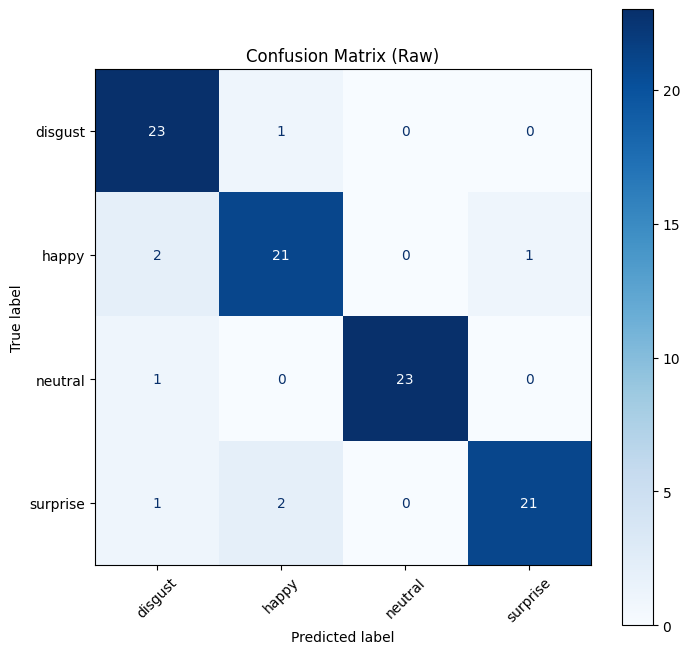

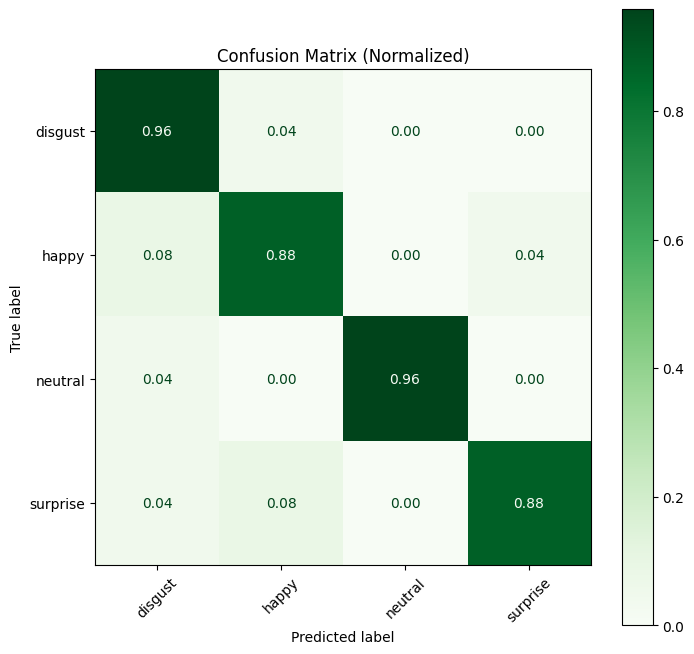

In [ ]:
# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)

## train model 2 (bhs inggris) whisper asli

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD DATA FROM FOLDER
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    df = pd.DataFrame(all_data)
    return df

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df["label"],
        random_state=seed
    )
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)


In [ ]:
def pad_or_truncate_mel(mel, target_length=3000):
    n_mels, time = mel.shape
    if time < target_length:
        pad_width = target_length - time
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :target_length]
    return mel


In [ ]:
def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio_array = batch["path"]["array"]
        mel = processor.feature_extractor(audio_array, sampling_rate=16000)["input_features"]
        mel = np.array(mel).squeeze()         # from [1, 80, T] to [80, T]
        mel = pad_or_truncate_mel(mel, 3000)  # ensure time = 3000

        return {"input_features": mel, "labels": batch["label_id"]}



    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset

In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=5,
        warmup_ratio=0.1,
        weight_decay=0.005,
        logging_steps=10,
        seed=42,
        fp16=True,
        max_grad_norm=1.0,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.close()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.close()

    # ✅ Save processor
    processor.save_pretrained(output_dir)
    print(f"✅ Processor saved to {output_dir}")


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification/inggris"
base_model_name = "openai/whisper-base"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

import wandb
wandb.init(mode="disabled")

# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)


✅ Loaded and split dataset
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64
✅ Processor Loaded


Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-9-418772490.py:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.365000,1.289103,0.500000,0.453960,0.719697,0.500000
2,0.920200,0.851349,0.854167,0.851786,0.875000,0.854167
3,0.403800,0.565942,0.895833,0.893416,0.918269,0.895833
4,0.217700,0.416194,0.916667,0.914222,0.924222,0.916667
5,0.248900,0.385120,0.916667,0.914222,0.924222,0.916667


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      0.75      0.86        12
       happy       0.92      0.92      0.92        12
     neutral       0.86      1.00      0.92        12
    surprise       0.92      1.00      0.96        12

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.91        48
weighted avg       0.92      0.92      0.91        48

✅ Processor saved to /content/drive/MyDrive/model/hasil-train-whisper-classification/indonesia


In [ ]:
print(df["label"].value_counts())

label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64


## train model 2 (bhs inggris) whisper

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD & PROCESS DATA
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    return pd.DataFrame(all_data)

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    return train_test_split(df, test_size=test_size, stratify=df["label"], random_state=seed)


In [ ]:
# =========================================================
# === 2. PREPARE DATASET
# =========================================================

def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio = batch["path"]["array"]
        inputs = processor(audio, sampling_rate=16000)
        return {"input_features": inputs["input_features"][0], "labels": batch["label_id"]}

    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset


In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
# =========================================================
# === 4. TRAINING FUNCTION
# =========================================================

def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=10,
        warmup_ratio=0.1,
        weight_decay=0.005,
        logging_steps=10,
        seed=42,
        fp16=True,
        max_grad_norm=1.0,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.close()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.close()


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# =========================================================
# === 5. MAIN PIPELINE
# =========================================================

# Config
allowed_labels = ["disgust", "happy", "neutral", "surprise"]
data_dir = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification/inggris"
base_model_name = "openai/whisper-base"

# Load & Encode
df = load_data_from_folder(data_dir, allowed_labels)
df, label2id, id2label = encode_labels(df)
train_df, test_df = stratified_split(df)

print("✅ Loaded and split dataset")
print(df["label"].value_counts())
print("Train:", train_df["label"].value_counts())
print("Test:", test_df["label"].value_counts())

# Processor
processor = WhisperProcessor.from_pretrained(base_model_name)
print("✅ Processor Loaded")

# Dataset
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("✅ Dataset Prepared")

import wandb
wandb.init(mode="disabled")

# Train
train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name)


✅ Loaded and split dataset
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✅ Processor Loaded


Map:   0%|          | 0/192 [00:00<?, ? examples/s]

Map:   0%|          | 0/48 [00:00<?, ? examples/s]

✅ Dataset Prepared


Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-10-3447341551.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.387800,1.351054,0.416667,0.344697,0.427083,0.416667
2,1.065600,1.008240,0.687500,0.589655,0.520739,0.687500
3,0.684200,0.605886,0.833333,0.801508,0.868269,0.833333
4,0.292800,0.480610,0.875000,0.861722,0.901786,0.875000
5,0.191500,0.196831,0.916667,0.915898,0.925000,0.916667
6,0.045600,0.245963,0.916667,0.914545,0.917308,0.916667
7,0.116200,0.165589,0.937500,0.935055,0.945055,0.937500
8,0.014000,0.170902,0.916667,0.914545,0.917308,0.916667
9,0.018400,0.114591,0.916667,0.914545,0.917308,0.916667
10,0.010000,0.113497,0.937500,0.935055,0.945055,0.937500


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        12
       happy       1.00      0.75      0.86        12
     neutral       0.86      1.00      0.92        12
    surprise       0.92      1.00      0.96        12

    accuracy                           0.94        48
   macro avg       0.95      0.94      0.94        48
weighted avg       0.95      0.94      0.94        48



## train model 3 (bhs gabungan) whisper

In [ ]:
# =========================================================
# === 0. IMPORTS
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from datasets import Dataset, Audio
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from transformers import (
    WhisperProcessor,
    WhisperForAudioClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)


In [ ]:
# =========================================================
# === 1. LOAD & PROCESS DATA
# =========================================================

def load_data_from_folder(data_dir, allowed_labels):
    all_data = []
    for label in os.listdir(data_dir):
        if label.lower() in allowed_labels:
            label_dir = os.path.join(data_dir, label)
            for file in os.listdir(label_dir):
                if file.endswith(".wav"):
                    all_data.append({
                        "path": os.path.join(label_dir, file),
                        "label": label.lower()
                    })
    return pd.DataFrame(all_data)

def encode_labels(df):
    unique_labels = sorted(df["label"].unique())
    label2id = {label: idx for idx, label in enumerate(unique_labels)}
    id2label = {v: k for k, v in label2id.items()}
    df["label_id"] = df["label"].map(label2id)
    return df, label2id, id2label

def stratified_split(df, test_size=0.2, seed=42):
    return train_test_split(df, test_size=test_size, stratify=df["label"], random_state=seed)


In [ ]:
# =========================================================
# === 2. PREPARE DATASET
# =========================================================

def prepare_dataset(train_df, test_df, processor):
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    train_dataset = train_dataset.cast_column("path", Audio(sampling_rate=16000))
    test_dataset = test_dataset.cast_column("path", Audio(sampling_rate=16000))

    def preprocess(batch):
        audio = batch["path"]["array"]
        inputs = processor(audio, sampling_rate=16000)
        return {"input_features": inputs["input_features"][0], "labels": batch["label_id"]}

    train_dataset = train_dataset.map(preprocess, remove_columns=["path", "label"])
    test_dataset = test_dataset.map(preprocess, remove_columns=["path", "label"])

    return train_dataset, test_dataset


In [ ]:
# =========================================================
# === 3. METRICS
# =========================================================

def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
    }


In [ ]:
def split_and_combine_datasets(
    indo_df, ravdess_df, test_size=0.2, seed=42
):
    from sklearn.model_selection import train_test_split

    # === Stratified split Indo ===
    train_indo, test_indo = train_test_split(
        indo_df,
        test_size=test_size,
        stratify=indo_df["label"],
        random_state=seed
    )
    print("\n✅ Split IndoWaveSentiment")
    print("Train:", train_indo["label"].value_counts())
    print("Test:", test_indo["label"].value_counts())

    # === Stratified split RAVDESS ===
    train_rav, test_rav = train_test_split(
        ravdess_df,
        test_size=test_size,
        stratify=ravdess_df["label"],
        random_state=seed
    )
    print("\n✅ Split RAVDESS")
    print("Train:", train_rav["label"].value_counts())
    print("Test:", test_rav["label"].value_counts())

    # === Combine ===
    final_train = pd.concat([train_indo, train_rav]).reset_index(drop=True)
    final_test = pd.concat([test_indo, test_rav]).reset_index(drop=True)

    print("\n✅ Combined Final Splits")
    print("Final Train:", final_train["label"].value_counts())
    print("Final Test:", final_test["label"].value_counts())

    return final_train, final_test


In [ ]:
# =========================================================
# === 4. TRAINING FUNCTION
# =========================================================

def train_model(train_dataset, eval_dataset, label2id, id2label, processor, output_dir, base_model_name):
    model = WhisperForAudioClassification.from_pretrained(
        base_model_name,
        num_labels=len(label2id),
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=4,
        num_train_epochs=10,
        warmup_ratio=0.1,
        weight_decay=0.005,
        logging_steps=10,
        seed=42,
        fp16=True,
        max_grad_norm=1.0,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor.feature_extractor,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()
    trainer.evaluate()

    # === Evaluation Report ===
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids

    print("\n=== Classification Report ===")
    target_names = [id2label[i] for i in sorted(id2label.keys())]
    report_text = classification_report(labels, preds, target_names=target_names)
    print(report_text)

    os.makedirs(output_dir, exist_ok=True)
    report_dict = classification_report(labels, preds, target_names=target_names, output_dict=True)
    pd.DataFrame(report_dict).transpose().to_csv(os.path.join(output_dir, "classification_report.csv"))

    # Confusion Matrix
    os.makedirs(os.path.join(output_dir, "confusion_matrices"), exist_ok=True)

    cm_raw = confusion_matrix(labels, preds)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=target_names)
    disp.plot(ax=ax, cmap="Blues", values_format="d", xticks_rotation=45)
    plt.title("Confusion Matrix (Raw)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_raw.png"))
    plt.close()

    cm_norm = confusion_matrix(labels, preds, normalize="true")
    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=target_names)
    disp.plot(ax=ax, cmap="Greens", values_format=".2f", xticks_rotation=45)
    plt.title("Confusion Matrix (Normalized)")
    plt.savefig(os.path.join(output_dir, "confusion_matrices", "confusion_matrix_normalized.png"))
    plt.close()


In [ ]:
import wandb
wandb.init(mode="disabled")

In [ ]:
# === 5.1 CONFIG ===
allowed_labels = ["disgust", "happy", "neutral", "surprise"]

# Data folders
data_dir_indo = "/content/drive/MyDrive/dataset/datasetindo_sorted_preprocess_4s"
data_dir_ravdess = "/content/drive/MyDrive/dataset/normalized_audio_emotions"
output_dir = "/content/drive/MyDrive/model/hasil-train-whisper-classification/gabungan"

base_model_name = "openai/whisper-base"  # atau small, medium

In [ ]:
# === 5.2 Load Data ===
df_indo = load_data_from_folder(data_dir_indo, allowed_labels)
df_ravdess = load_data_from_folder(data_dir_ravdess, allowed_labels)

print("\n✅ Loaded datasets")
print(df_indo['label'].value_counts())
print(df_ravdess['label'].value_counts())


✅ Loaded datasets
label
neutral     60
surprise    60
disgust     60
happy       60
Name: count, dtype: int64
label
surprise    60
disgust     60
neutral     60
happy       60
Name: count, dtype: int64


In [ ]:
# === 5.3 Encode labels consistently ===
all_data = pd.concat([df_indo, df_ravdess]).reset_index(drop=True)
all_data, label2id, id2label = encode_labels(all_data)

# Apply mapping back
df_indo["label_id"] = df_indo["label"].map(label2id)
df_ravdess["label_id"] = df_ravdess["label"].map(label2id)

print("\n✅ Labels encoded")
print(label2id)


✅ Labels encoded
{'disgust': 0, 'happy': 1, 'neutral': 2, 'surprise': 3}


In [ ]:
# === 5.4 Split each domain and combine ===
train_df, test_df = split_and_combine_datasets(df_indo, df_ravdess)


✅ Split IndoWaveSentiment
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64

✅ Split RAVDESS
Train: label
happy       48
neutral     48
surprise    48
disgust     48
Name: count, dtype: int64
Test: label
disgust     12
surprise    12
neutral     12
happy       12
Name: count, dtype: int64

✅ Combined Final Splits
Final Train: label
happy       96
neutral     96
surprise    96
disgust     96
Name: count, dtype: int64
Final Test: label
disgust     24
surprise    24
neutral     24
happy       24
Name: count, dtype: int64


In [ ]:
# === 5.5 Processor ===
processor = WhisperProcessor.from_pretrained(base_model_name)
print("\n✅ Processor Loaded")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



✅ Processor Loaded


In [ ]:
# === 5.6 HF Dataset ===
train_dataset, eval_dataset = prepare_dataset(train_df, test_df, processor)
print("\n✅ Dataset Prepared")

Map:   0%|          | 0/384 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]


✅ Dataset Prepared


In [ ]:
# === 5.7 WandB OFF ===
import wandb
wandb.init(mode="disabled")

In [ ]:
# === 5.8 Train Model ===
train_model(
    train_dataset,
    eval_dataset,
    label2id,
    id2label,
    processor,
    output_dir,
    base_model_name
)

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-6-3447341551.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.291200,1.184316,0.604167,0.524496,0.798611,0.604167
2,0.726100,0.601859,0.781250,0.764929,0.794499,0.781250
3,0.238300,0.339062,0.895833,0.891489,0.909443,0.895833
4,0.191200,0.254306,0.927083,0.923380,0.936508,0.927083
5,0.007300,0.312823,0.937500,0.934874,0.944444,0.937500
6,0.005000,0.189046,0.958333,0.957465,0.962222,0.958333
7,0.003500,0.204667,0.958333,0.957465,0.962222,0.958333
8,0.003000,0.230508,0.958333,0.957465,0.962222,0.958333
9,0.002600,0.240496,0.958333,0.957465,0.962222,0.958333


/usr/local/lib/python3.11/dist-packages/transformers/configuration_utils.py:407: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50358, 50


=== Classification Report ===
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00        24
       happy       1.00      0.83      0.91        24
     neutral       0.89      1.00      0.94        24
    surprise       0.96      1.00      0.98        24

    accuracy                           0.96        96
   macro avg       0.96      0.96      0.96        96
weighted avg       0.96      0.96      0.96        96

